In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [5]:
indicators=pd.read_csv("RHoMISmother_indicators.csv")
codebook=pd.read_csv("raw data code book.csv")

In [6]:
raw=pd.read_csv("RHoMISmother_rawdata.csv",encoding = "ISO-8859-1")

C:\Users\Clare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7,8,29,46,48,49,58,65,70,77,80,84,97,119,121,122,123,124,125,126,127,129,133,134,136,137,139,141,142,145,146,147,149,150,153,155,158,164,166,171,173,249,270,285,294,301,316,319,330,334,337,348,355,366,370,373,377,378,379,381,382,383,384,385,386,387,388,390,392,393,394,395,396,397,399,400,401,402,403,404,405,406,408,410,411,412,413,414,415,417,418,419,420,421,422,423,424,426,428,429,430,443,444,456,462,469,475,499,500,514,515,517,519,525,531,535,536,538,539,541,542,555,556,561,565,569,570,571,573,575,576,581,587,591,592,594,595,597,598,611,612,614,615,617,619,621,625,626,627,629,631,632,637,639,640,642,644,645,647,648,650,651,653,654,655,656,658,660,664,665,667,668,669,670,671,674,675,689,691,693,694,703,704,706,707,709,710,719,723,724,726,727,728,729,730,735) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, r

In [7]:
# looking for duds in the HFIAS data
raw['HHid']=raw['HouseholdID']
HFIAS_data=pd.merge(raw[['HHid','HFIAS_1','HFIAS_2','HFIAS_3','HFIAS_4','HFIAS_5','HFIAS_6','HFIAS_7','HFIAS_8','HFIAS_9']],indicators[['HHid','HFIAS_status']],on='HHid')
HFIAS_most_null=[]
for i in range(len(HFIAS_data)):
    n=0
    for j in range(9):
        if pd.isnull( HFIAS_data.iloc[i,j+1] ):
            n+=1
    if n>=7:
        HFIAS_most_null.append(HFIAS_data.loc[i,'HHid'])
HFIAS_

In [119]:
# create a numerical column for HFIAS status
# and this column will remove the really shit ones from the list of shit ones
# and a new column for income_percap
prob=0
for i in range(len(indicators)):
    if indicators.loc[i,'HHid'] in HFIAS_most_null:
        indicators.loc[i,'HFIAS_code']=None
    elif str(indicators.loc[i,'HFIAS_status'])=='FoodSecure':
        indicators.loc[i,'HFIAS_code']=0
    elif str(indicators.loc[i,'HFIAS_status'])=='MildlyFI':
        indicators.loc[i,'HFIAS_code']=1
    elif str(indicators.loc[i,'HFIAS_status'])=='ModeratelyFI':
        indicators.loc[i,'HFIAS_code']=2
    elif str(indicators.loc[i,'HFIAS_status'])=='SeverelyFI':
        indicators.loc[i,'HFIAS_code']=3
        continue
    else:
        prob+=1
zero=0
dz=0
for i in range(len(indicators)):
    if indicators.loc[(i,'HHsizeMAE')]!=0:
        indicators.loc[(i,'income_percap')]=np.divide(indicators.loc[(i,'total_income')],indicators.loc[(i,'HHsizeMAE')])
    else: 
        zero+=1
        if indicators.loc[(i,'HHsizemembers')]==0:
            dz+=1
            indicators.loc[(i,'income_percap')]=indicators.loc[(i,'total_income')]
        else:
            indicators.loc[(i,'income_percap')]=np.divide(indicators.loc[(i,'total_income')],indicators.loc[(i,'HHsizemembers')])
# make a new income percentile column
percentiles=np.zeros(10)
maps=np.arange(0,10,1)
for i in range(9):
    j=np.divide(i+1,10)
    percentiles[i+1]=indicators['income_percap'].quantile (q=j, interpolation='linear')
print(percentiles,maps)
indicators['inc_pc_perc']=None
for m in range(len(indicators)):
    k=9
    while indicators.loc[(m,'income_percap')]<percentiles[k]:
        k-=1
    indicators.loc[(m,'inc_pc_perc')]=maps[k]
indicators['inc_pc_perc']=pd.DataFrame(indicators['inc_pc_perc'],dtype='float')
print('There were problems in ',prob,' rows.')
print('There were ',zero,' households with no MAE. Of these, ',dz,' were recorded with no members at all.')

[  0.00000000e+00   1.84342857e-01   1.05003592e+01   2.58949485e+01
   5.14872286e+01   9.41080196e+01   1.56888886e+02   2.67285105e+02
   4.76762123e+02   1.09783781e+03] [0 1 2 3 4 5 6 7 8 9]
There were problems in  0  rows.
There were  36  households with no MAE. Of these,  15  were recorded with no members at all.


In [120]:
hunger=indicators[['HHid','score_PPI','HFIAS_code','score_HDDSBadSeason','income_percap','inc_pc_perc','HDDS_farmbasedBadSeason','HDDS_purchasedBadSeason','CropDiv','LivestockDiv','FAEnergyOffFarm','FAEnergyFarmBased','FAMarketOrientation','NrofMonthsFoodInsecure','Country']]

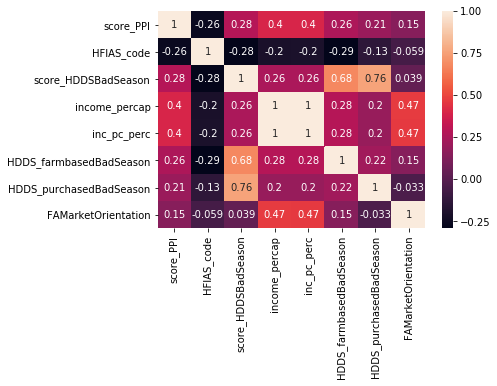

In [209]:
sns.heatmap(hunger[['score_PPI','HFIAS_code','score_HDDSBadSeason','income_percap','inc_pc_perc','HDDS_farmbasedBadSeason','HDDS_purchasedBadSeason','FAMarketOrientation']].corr(method='spearman'),annot=True)

In [204]:
#setting up the model
X=hunger[['score_PPI','inc_pc_perc','CropDiv','LivestockDiv','FAMarketOrientation']]
# y=hunger[['HFIAS_code','score_HDDSBadSeason','NrofMonthsFoodInsecure']]
y=hunger[['score_HDDSBadSeason']]
d=np.ones((len(X),1))*10
dummy=pd.DataFrame(d,columns=[['dummy']])
Xd=pd.concat([X,dummy],axis=1)
X_tr,X_test,y_tr,y_test=train_test_split(Xd,y)
y_test.head()

,score_HDDSBadSeason
3,4.0
2516,NaN
4004,3.0
3603,1.0
1830,10.0


In [205]:
b_c=np.zeros((pow(2,5),5))
for i in range (1,pow(2,5)):
    if b_c[i-1,4]==0:
        b_c[i,4]=1
    else:
        b_c[i,4]=0
    for k in range(4):
        j=3-k
        if b_c[i,j+1]==0:
            if b_c[i-1,j]==0:
                b_c[i,j]=1
                break
            else:
                b_c[i,j]=0
        else:
            b_c[i,j]=b_c[i-1,j]
            break
    for l in range(k+1,4):
        j=3-l
        b_c[i,j]=b_c[i-1,j]
        
b_c

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  1.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.,  1.],
       [ 0.,  1.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  1.],
       [ 0.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  1.,  1.],
       [ 1.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  1.],
       [ 1.,  0.,  1.,  1.,  0.],
       [ 1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  1.],
       [ 1.,  1.,  0.,  1.,  0.],
       [ 1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  0.],
       [ 1.,  

In [208]:
test=pd.concat([X_test,y_test], axis=1)
test.dropna(inplace=True)
test_x=test.iloc[:,:5]
test_y=test.iloc[:,6]

models={}
R=0.14
for i in range(len(b_c)):
#for i in range(1):
    if b_c[i,0]==0:
        d=X_tr['dummy']
    else:
        d=X_tr.iloc[:,0]
    for j in range(1,5):
        if b_c[i,j]==0:
            e=X_tr['dummy']
        else:
            e=X_tr.iloc[:,j]
        d=pd.concat([d, e],axis=1)
    final=pd.concat([d,y_tr],axis=1)
    final.dropna(inplace=True)
    fin_x=final.iloc[:,:5]
    fin_y=final.iloc[:,5]
    m=LinearRegression().fit(fin_x,fin_y)
    if m.score(test_x,test_y) >=R:
        models[i]=(m,(b_c[i,:], m.score(test_x,test_y)))
        print(b_c[i,:],m.score(test_x,test_y),m.coef_)


[ 1.  1.  0.  0.  0.] 0.143743998734 [ 0.03584824  0.15465467  0.          0.          0.        ]
[ 1.  1.  0.  0.  1.] 0.14502927279 [ 0.03558022  0.19649723  0.          0.         -0.82184597]
[ 1.  1.  0.  1.  0.] 0.142730684588 [ 0.03593266  0.15077136  0.          0.03001166  0.        ]
[ 1.  1.  0.  1.  1.] 0.144919185167 [  3.55913922e-02   1.95905261e-01  -8.60422844e-16   3.31320455e-03
  -8.18134985e-01]
[ 1.  1.  1.  0.  0.] 0.144058262234 [ 0.03496618  0.15259749  0.061953    0.          0.        ]
[ 1.  1.  1.  0.  1.] 0.144956159743 [ 0.03453927  0.19746996  0.06426003  0.         -0.83739341]
[ 1.  1.  1.  1.  0.] 0.143456969612 [ 0.03503974  0.15047876  0.06011459  0.01684615  0.        ]
[ 1.  1.  1.  1.  1.] 0.145322199213 [ 0.03448554  0.19937789  0.06537336 -0.01058418 -0.84951768]


In [207]:
len(models)

19

In [145]:
test_x.columns

Index(['score_PPI', 'income_percap', 'inc_pc_perc', 'CropDiv', 'LivestockDiv',
       'FAEnergyOffFarm', 'FAEnergyFarmBased', 'FAMarketOrientation'],
      dtype='object')